<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/GWP03_3573.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 622 STOCHASTIC MODELING
## Student Group 3573
# GWP03


* Alper Ulku (alperulku1970@gmail.com)
* Kwan Wei Ma (kwanweima@gmail.com)

In [1]:
Financial_List = [ "JPM","WFC","BAC","C","GS","USD","MS","KEY","PNC","COF","AXP","PRU","SCHW"] # BBT and STI not found in yahoo finance
Non_Financial_List = ["KR","PFE","XOM","WMT","DAL","CSCO","EQIX","DUK","NFLX","GE","APA","F","REGN","CMS"] #HCP list in 2021
ALL = Financial_List + Non_Financial_List


import datetime
import yfinance as yf
import pandas as pd
from datetime import date, datetime, timedelta
import time
import numpy as np
from numpy.random import rand, seed
import matplotlib.pyplot as plt
import seaborn as sns


T0_START = '2008-01-01'
T0_END   = '2008-12-31'
T1_START = '2020-01-01'
T1_END   = '2020-12-31'


# Stp 3: Import and Structure Data for 2008

In [2]:

def DownloadAssetsConvertDataframe(tickers, startTime, endTime):


    prices = pd.DataFrame()

    print(f"Comparing assets for Sharpe and Std Dev")

    names = []

    for tick in tickers:
            print(f"Downloading {tick}")
            yf_tick = yf.Ticker(tick)
            df = yf_tick.history(interval='1d', auto_adjust=True, start=startTime, end=endTime, back_adjust = True, rounding=True)
            df.dropna(how='all', inplace=True)
            prices = pd.concat([prices,df['Close']],axis=1, ignore_index=False)
            names.append(tick)

    prices.index = pd.to_datetime(prices.index)
    prices.index = prices.index.strftime('%Y-%m-%d')

    prices.columns = names
    prices= prices.dropna()

    returns = np.log(prices) - np.log(prices.shift(1))
    returns = returns.iloc[1:, 0:]

    return prices, returns



In [3]:
Prices0, Returns0 = DownloadAssetsConvertDataframe(ALL, T0_START, T0_END)
YData0 = Prices0.to_numpy()
YData0_dates = Prices0.index

Comparing assets for Sharpe and Std Dev


# Step 4 Correlation Matrix

In [4]:
def PlotCorrelations(log_returns, CORR_FILTER):
    print("30x30 correlation matrix is:")
    print(log_returns.corr())
    plt.figure(figsize=(18,18))
    plt.title(f"Cross Correlations of Assets")
    print("30x30 correlation heatmap is:")
    sns.heatmap(log_returns.corr(),linecolor='white',linewidths=1,annot=True)
    plt.savefig(f"Chart_01_Coorelation.jpg", format='jpg', dpi=300)
    plt.show()

    plt.figure(figsize=(18,18))
    mask = np.triu(np.ones_like(log_returns.corr()))
    heatmap = sns.heatmap(log_returns.corr(),mask=mask, vmin=-1,vmax=1,cmap='coolwarm', annot=True)
    heatmap.set_title('Correlation heatmap', fontdict={'fontsize':12},pad=12);
    plt.savefig(f"Chart_02_TriangularCorrelation.jpg", format='jpg', dpi=300)
    plt.show()

    plt.figure(figsize=(18,18))
    c = log_returns.corr()
    heatmap = sns.heatmap((c >= CORR_FILTER) ,linecolor='white',linewidths=1,annot = True)
    heatmap.set_title(f'Selective Correlation heatmap with Correlation > {CORR_FILTER}', fontdict={'fontsize':12},pad=12);
    plt.savefig(f"Chart_03_Selective Correlation.jpg", format='jpg', dpi=300)
    plt.show()


    plt.figure(figsize=(22,22))
    heatmap = sns.clustermap(log_returns.corr(),row_cluster=True, vmin=-1,vmax=1,cmap='coolwarm', annot=True)
    plt.savefig(f"Chart_04_ClusterCorrelation.", format='jpg', dpi=300)
    plt.show()


30x30 correlation matrix is:
           JPM       WFC       BAC         C        GS       USD        MS  \
JPM   1.000000  0.832941  0.860311  0.795487  0.669596  0.594068  0.569412   
WFC   0.832941  1.000000  0.845507  0.756024  0.690884  0.578473  0.616430   
BAC   0.860311  0.845507  1.000000  0.842201  0.733940  0.593960  0.682470   
C     0.795487  0.756024  0.842201  1.000000  0.710928  0.571217  0.639324   
GS    0.669596  0.690884  0.733940  0.710928  1.000000  0.566807  0.824474   
USD   0.594068  0.578473  0.593960  0.571217  0.566807  1.000000  0.583492   
MS    0.569412  0.616430  0.682470  0.639324  0.824474  0.583492  1.000000   
KEY   0.672125  0.723061  0.761691  0.717328  0.655772  0.470557  0.640097   
PNC   0.845756  0.805129  0.758203  0.686096  0.527362  0.549970  0.477473   
COF   0.785140  0.803141  0.807711  0.723650  0.672061  0.661440  0.634875   
AXP   0.734978  0.744155  0.771527  0.698747  0.713341  0.704732  0.721770   
PRU   0.571296  0.652521  0.639624 

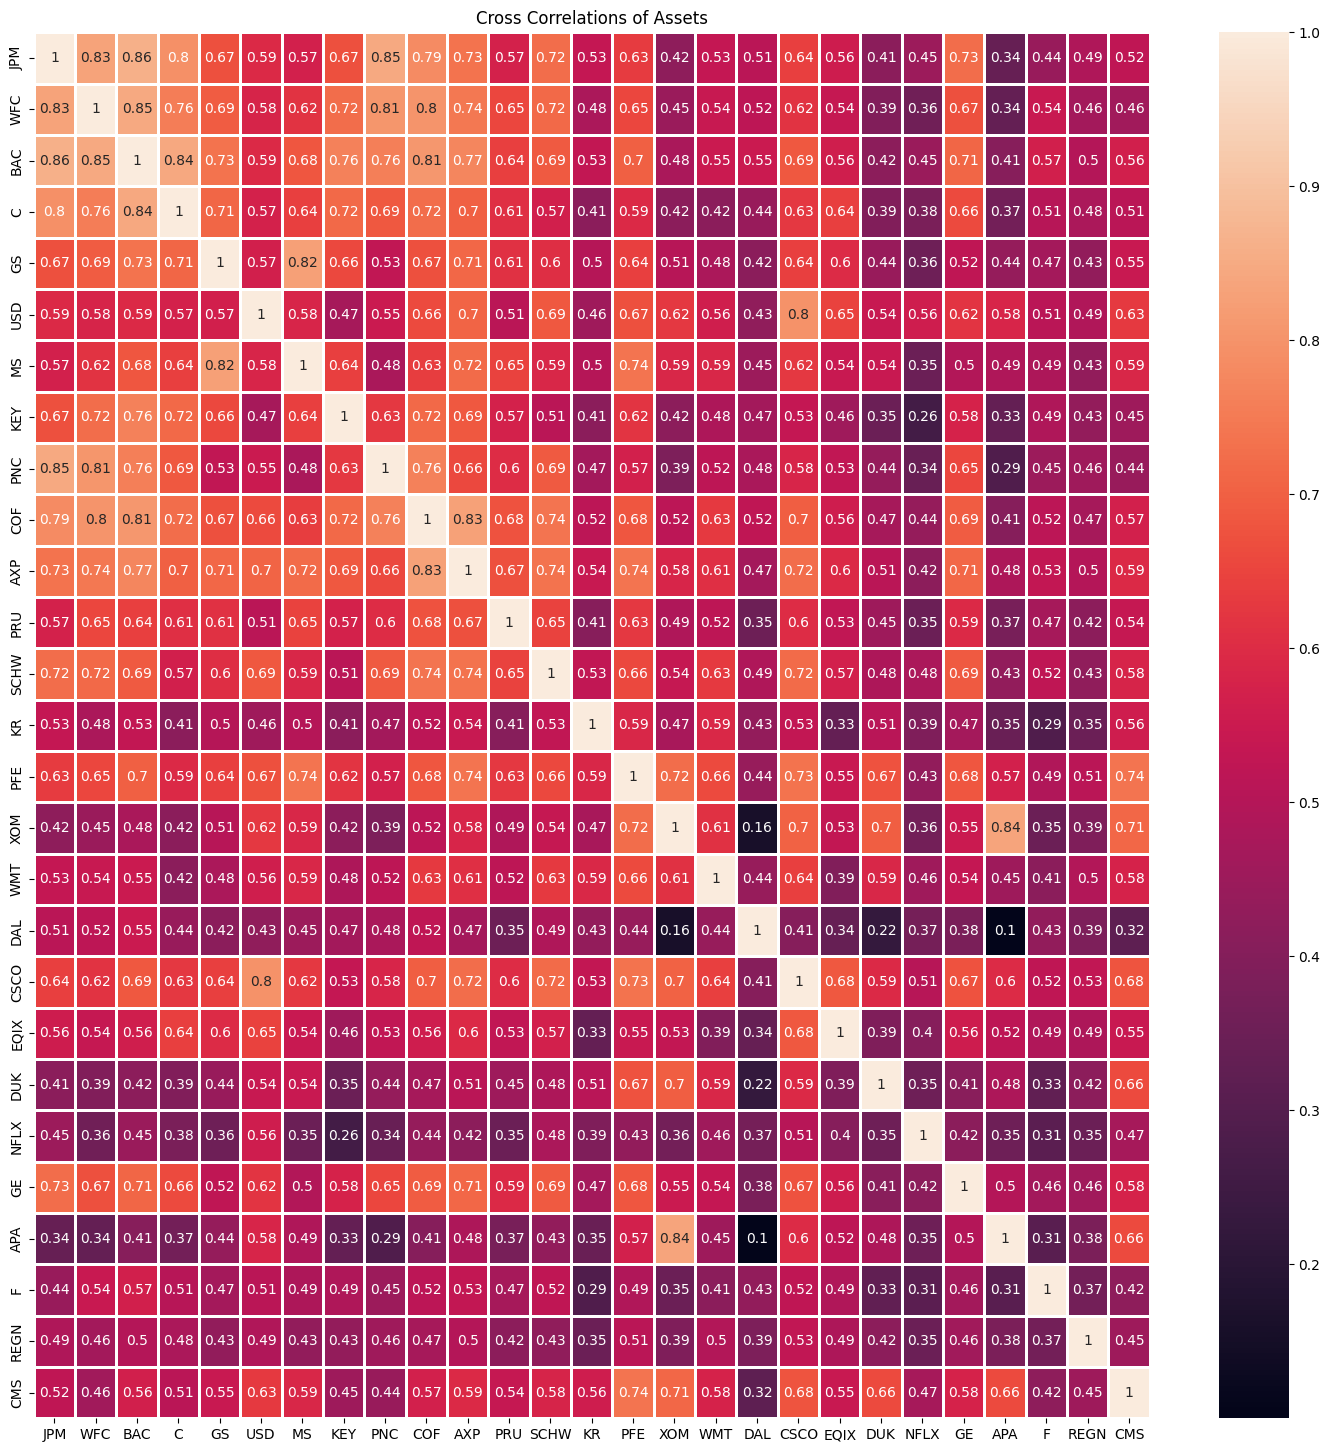

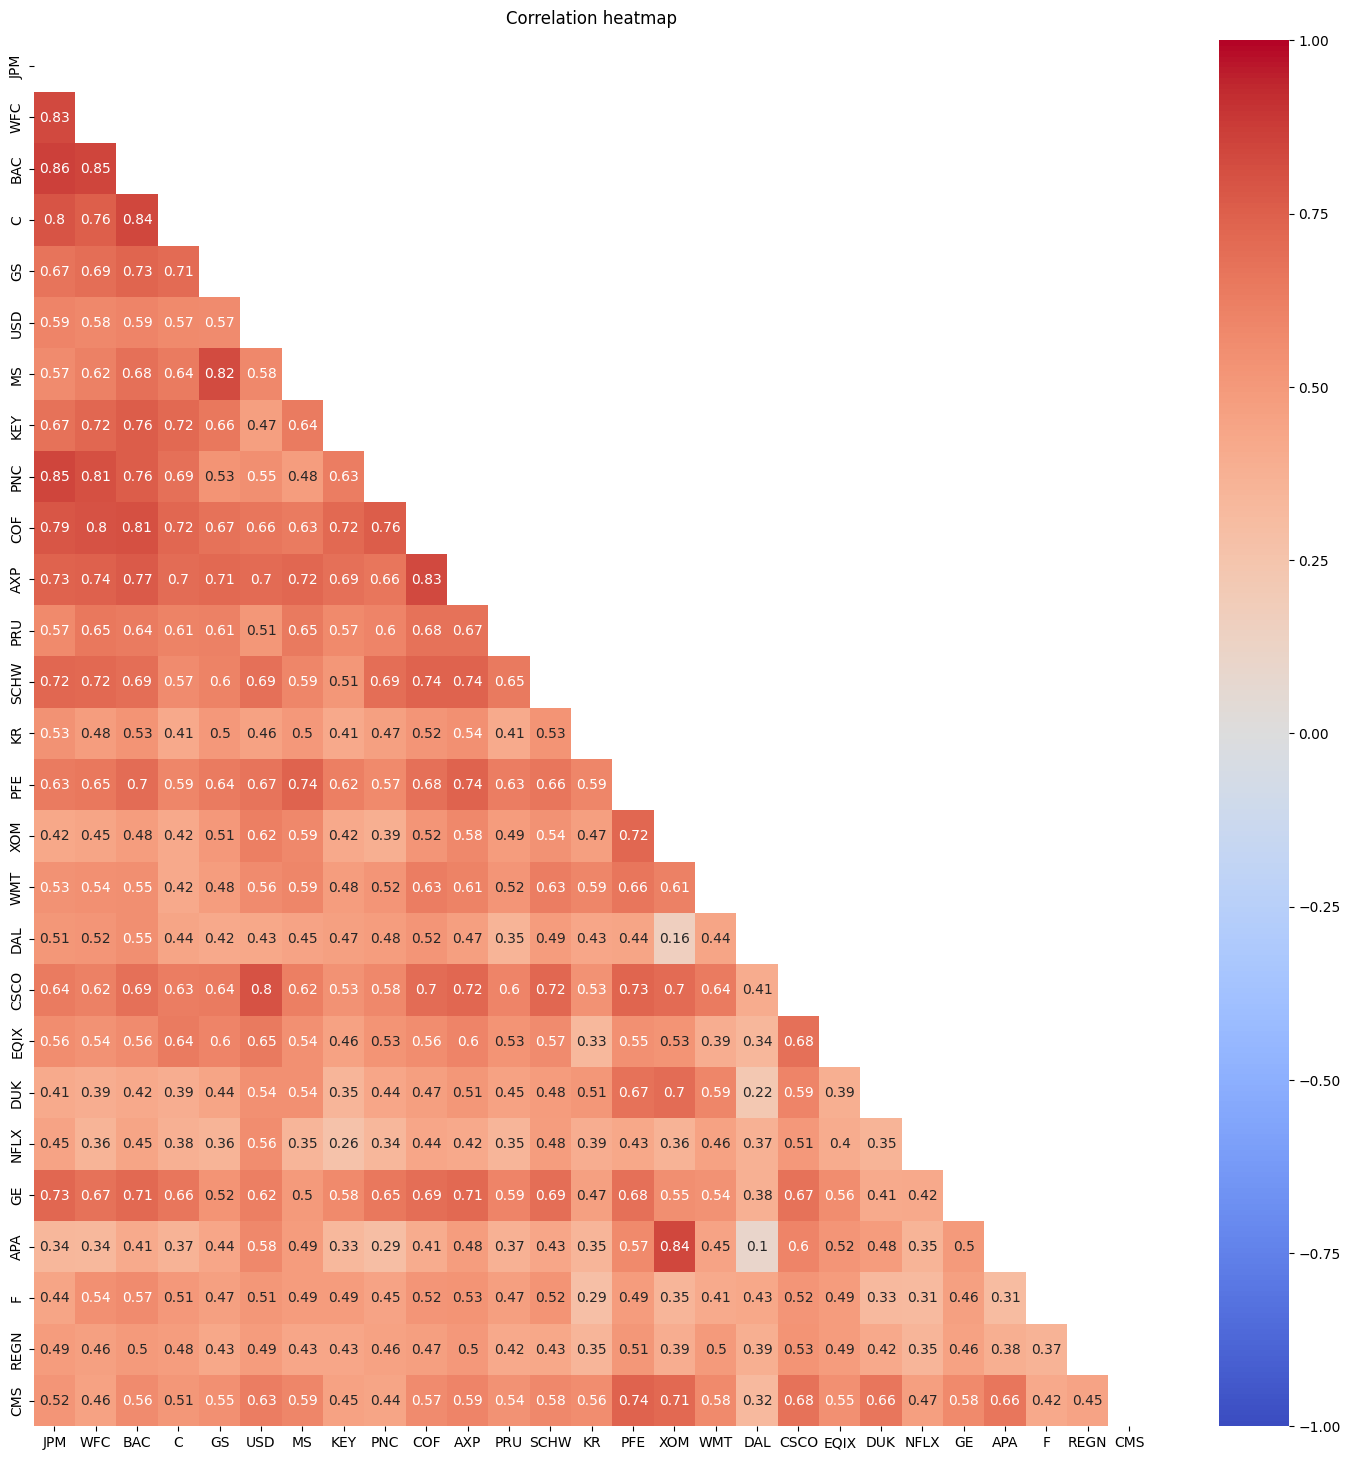

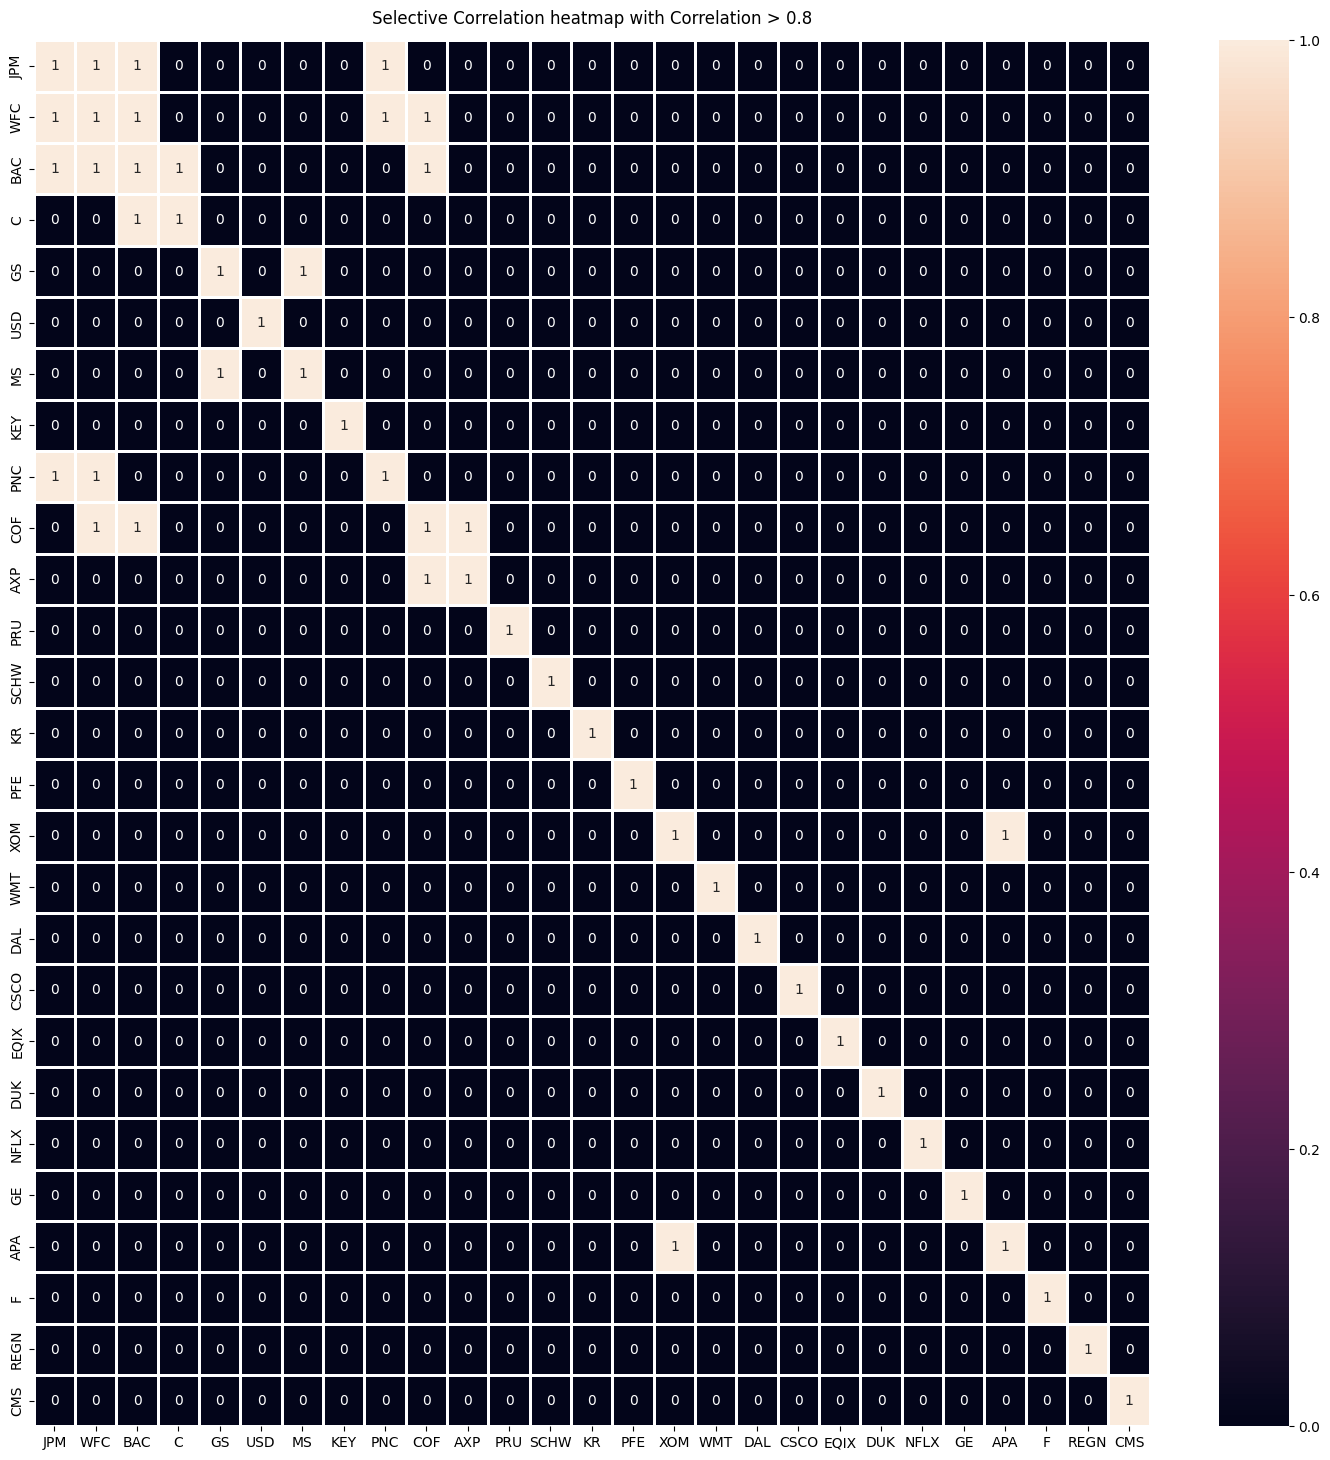

<Figure size 2200x2200 with 0 Axes>

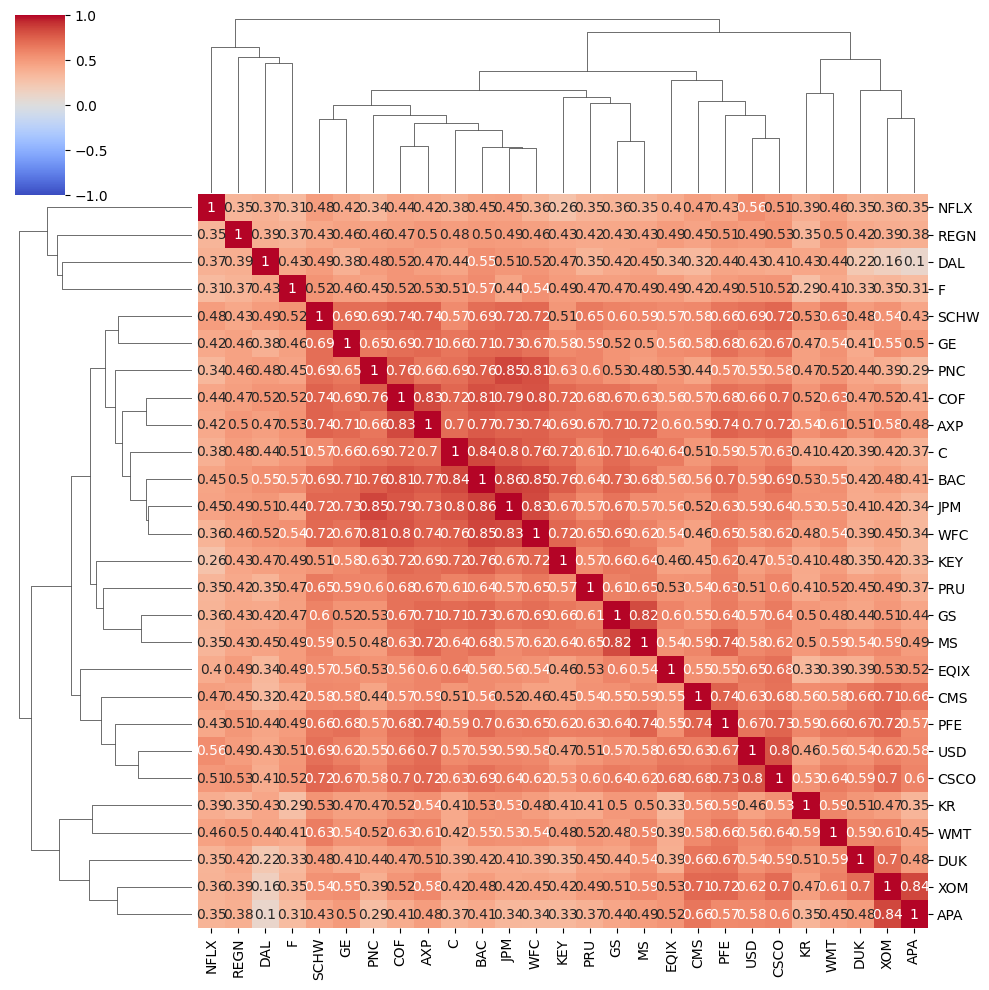

In [5]:
PlotCorrelations(Returns0, CORR_FILTER= 0.8)

# Step 6 Upper-Confidence Bound (UBC) algorithm

In [6]:
def optimal_action(qvalue, eps):  # noQA E203
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:  # noQA E203
                break
    elif action_hat[0].shape[0] > 1:  # noQA E203
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):  # noQA E203
            if randnum < (aa + 1) / action_hat[0].shape[0]:  # noQA E203
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa


def reward_update(action, reward, qvalue_old, alpha):  # noQA E203
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new


In [ ]:
# Bandit problem for stock selection

NK = len(ALL)
EPSILON = 0.1
ALPHA = 0.975
NEPISODES = 1000
HOLD = 1
TMAX = YData0.shape[0] - HOLD
UCB_weight = 1.0

seed(1234)


reward_avg = np.zeros((TMAX))
optimal_avg = np.zeros((TMAX))
reward_queue = np.zeros((HOLD, 2))

for run in range(NEPISODES):  # noQA E203
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    qvalue_up = np.zeros((NK))
    nactions = np.zeros((NK))
    for tt in range(TMAX):  # noQA E203
        aa_opt = optimal_action(qvalue_up, EPSILON)
        nactions[aa_opt] += 1
        # Compute reward as return over holding period
        reward_queue[HOLD - 1, 0] = (
            YData0[tt + HOLD, aa_opt] - YData0[tt, aa_opt]
        ) / YData0[tt, aa_opt]
        reward_queue[HOLD - 1, 1] = aa_opt
        # Update Q function using action chosen HOLD days before
        qvalue = reward_update(
            int(reward_queue[0, 1]), reward_queue[0, 0], qvalue, ALPHA
        )
        # Upper-confidence adjustment
        qvalue_up = np.zeros((NK))
        for aa in range(NK):
            if nactions[aa] == 0:  # noQA E203
                qvalue_up[aa] = np.max(qvalue) + 1.0
            else:
                qvalue_up[aa] = qvalue[aa] + UCB_weight * np.sqrt(np.log(tt + 1) / nactions[aa])
        reward_queue[0 : HOLD - 1, :] = reward_queue[1:HOLD, :]  # noQA E203
        reward_avg[tt] += reward_queue[HOLD - 1, 0] / NEPISODES
        optimal_avg[tt] += (
            aa_opt == np.argmax((YData0[tt + HOLD, :] - YData0[tt, :]) / YData0[tt, :])
        ) / NEPISODES  # noQA E203

In [ ]:
plt.plot(YData0_dates[HOLD : YData0.shape[0]], optimal_avg)  # noQA E203
plt.title("Frequency of optimal action", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Step 8 Epsilon-greedy algorithm.

In [ ]:
# EXAMPLE OF A STATIONARY k-BANDIT PROBLEM
# Parameters
NK = len(ALL)
ITEMAX = 1000
EPSILON_M = [0.0, 0.1]
NEPISODES = 1000

seed(1234)

# Initialize actual distribution of each bandit
NMEANS = np.random.normal(loc=0.0, scale=1.0, size=NK)

print(NMEANS)

In [ ]:
reward_avg = np.zeros((ITEMAX, 2))
optimal_avg = np.zeros((ITEMAX, 2))
for ee in range(2):
    epsilon = EPSILON_M[ee]
    for run in range(NEPISODES):
        # Initialize q function and actions record
        qvalue = np.zeros((NK))
        nchoices = np.zeros((NK))
        for tt in range(ITEMAX):
            aa_opt = optimal_action(qvalue, epsilon)
            reward = np.random.normal(loc=NMEANS[aa_opt], scale=1.0)
            nchoices[aa_opt] += 1  # update with avg. number of times aa_opt was chosen
            qvalue = reward_update(aa_opt, reward, qvalue, 1 / nchoices[aa_opt])
            reward_avg[tt, ee] += reward / NEPISODES
            optimal_avg[tt, ee] += (aa_opt == np.argmax(NMEANS)) / NEPISODES

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(reward_avg[:, 0], label="Greedy")
plt.plot(reward_avg[:, 1], label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Average reward", fontsize="x-large")
legend = plt.legend(loc="lower right", shadow=True, fontsize="x-large")
plt.subplot(1, 2, 2)
plt.plot(optimal_avg[:, 0], label="Greedy")
plt.plot(optimal_avg[:, 1], label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Frequency of optimal action", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

# Step 10 Import and Structure Data for 2020

In [ ]:
Prices1, Returns1 = DownloadAssetsConvertDataframe(ALL, T1_START, T1_END)
YData1 = Prices1.to_numpy()
YData1_dates = Prices1.index

In [ ]:
plt.plot(YData1_dates, YData1  / YData1 [0, :])  # noQA E203
plt.legend(ALL,loc='lower right', shadow=True,fontsize='xx-small')
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.show()